**MACHINE LEARNING PROBLEM 1 TASK 2**

Gonçalo Ribeiro (100306) and Inês Nunes (100346)

NOTE: WE STILL NEED TO CHOOSE THE REGRESSOR AND THE PARAMETERS. WE SHOULD ALSO CHECK IF IN THE LAST CELLS THE VALUE ARE BEING COMPUTED CORRECTLY.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

In [2]:
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')

In [3]:
def create_arx_regressor(y, u, n, m, d):
    N = len(y)
    p = max(n, d + m)
    X = []
    Y = []
    
    for k in range(p, N):
        y_lags = [y[k - i] for i in range(1, n+1)]
        u_lags = [u[k - d - j] for j in range(m + 1)]
        X.append(y_lags + u_lags)
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [ ]:
best_score = -np.inf
best_params = {}

n_range = range(1, 10)
m_range = range(1, 10)
d_range = range(1, 10) 

# Grid search over n, m, and d
for n in n_range:
    for m in m_range:
        for d in d_range:
            
            X_train, Y_train = create_arx_regressor(output_train, u_train, n, m, d)
            
            sample_size = X_train.shape[0]
            test_size = int(0.2*sample_size)
            
            X_train_split = X_train[:-test_size] 
            Y_train_split = Y_train[:-test_size] 
            
            X_val_split = X_train[-test_size:]  
            Y_val_split = Y_train[-test_size:] 
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)
            y_val = []
            aux = np.zeros(n)
            y_prev = list(Y_train_split[-n:][::-1])
            
            for k in range(test_size):
                u_lags = X_val_split[k, n:]  
                combined_input = y_prev + list(u_lags)[:m + 1]
                y_pred = lr.predict([combined_input]) 
                y_val.append(y_pred[0])
                aux[:] = y_prev[:] 
                y_prev[0] = y_pred[0]
                for i in range(1, n):
                    y_prev[i] = aux[i-1]
            score = r2_score(Y_val_split, y_val)
            mse = mean_squared_error(Y_val_split, y_val)
            if score > best_score:
                best_score = score
                best_mse = mse
                best_params = {'n': n, 'm': m, 'd': d}

print(f"Best n, m, d: {best_params}, with R² score: {best_score} and MSE: {best_mse}")


In [34]:
n_final, m_final, d_final = 6,9,6

X_train, Y_train = create_arx_regressor(output_train, u_train, n_final, m_final, d_final)

sample_size = X_train.shape[0]
test_size = int(0.2*sample_size)

X_train_split = X_train[:-test_size] 
Y_train_split = Y_train[:-test_size] 

X_val_split = X_train[-test_size:]  
Y_val_split = Y_train[-test_size:] 

alpha_values = np.linspace(1e-5,1,10)
l1_ratios = np.linspace(0.1,1,10)

0.9994628058907725
0.01755133453873566


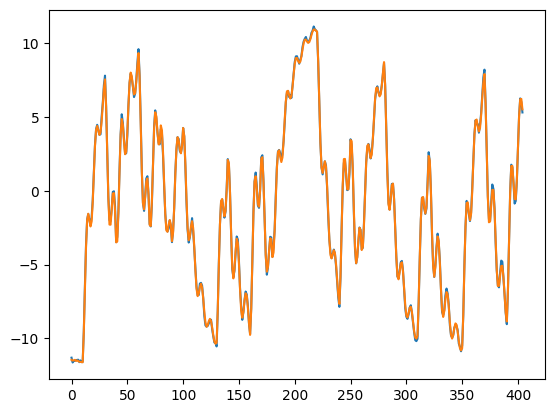

In [24]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train_split, Y_train_split)
y_val_OLS = []
aux = np.zeros(n_final)
y_prev = list(Y_train_split[-n_final:][::-1])
for k in range(test_size):
    u_lags = X_val_split[k, n_final:] 
    combined_input = y_prev + list(u_lags)[:m_final + 1]
    y_pred = lr.predict([combined_input])
    y_val_OLS.append(y_pred[0])
    aux[:] = y_prev[:]
    y_prev[0] = y_pred[0]
    for i in range(1, n_final):
        y_prev[i] = aux[i-1]
print(r2_score(Y_val_split, y_val_OLS))
print(mean_squared_error(Y_val_split, y_val_OLS))
plt.plot(Y_val_split, label='True')
plt.plot(y_val_OLS, label='OLS')

            alpha       mse  r2_score
0    1.000000e-08  0.017551  0.999463
1    1.001101e-04  0.017551  0.999463
2    2.002102e-04  0.017551  0.999463
3    3.003103e-04  0.017551  0.999463
4    4.004104e-04  0.017551  0.999463
..            ...       ...       ...
995  9.959960e-02  0.017556  0.999463
996  9.969970e-02  0.017556  0.999463
997  9.979980e-02  0.017556  0.999463
998  9.989990e-02  0.017556  0.999463
999  1.000000e-01  0.017556  0.999463

[1000 rows x 3 columns]


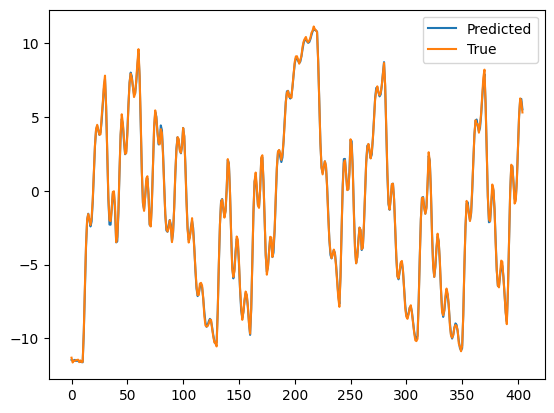

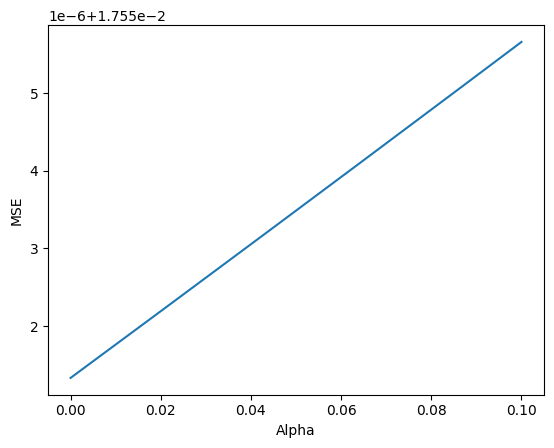

In [28]:
results = [] 

for alpha in alpha_values:
        ridge = Ridge(alpha=alpha,fit_intercept=False)
        ridge.fit(X_train_split, Y_train_split)
        y_val_ridge = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = ridge.predict([combined_input])
                y_val_ridge.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n_final):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_ridge)
        mse = mean_squared_error(Y_val_split, y_val_ridge)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_ridge, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

            alpha       mse  r2_score
4    4.004104e-04  0.017915  0.999452
3    3.003103e-04  0.017918  0.999452
2    2.002102e-04  0.017922  0.999451
1    1.001101e-04  0.017927  0.999451
0    1.000000e-08  0.017928  0.999451
..            ...       ...       ...
995  9.959960e-02  0.236390  0.992765
996  9.969970e-02  0.236618  0.992758
997  9.979980e-02  0.236888  0.992750
998  9.989990e-02  0.237157  0.992741
999  1.000000e-01  0.237426  0.992733

[1000 rows x 3 columns]


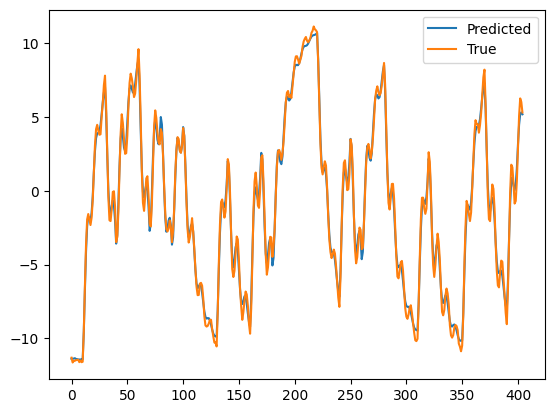

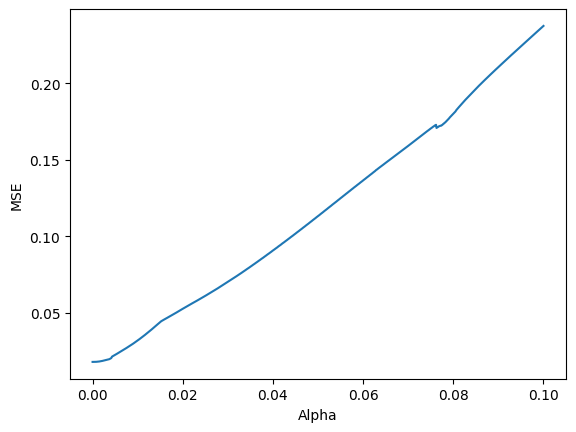

In [32]:
results = [] 

for alpha in alpha_values:
        lasso = Lasso(alpha=alpha,max_iter=100000,fit_intercept=False)
        lasso.fit(X_train_split, Y_train_split)
        y_val_lasso = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = lasso.predict([combined_input])
                y_val_lasso.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n_final):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_lasso)
        mse = mean_squared_error(Y_val_split, y_val_lasso)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_lasso, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [36]:
results = [] 

for l1 in l1_ratios:
        for alpha in alpha_values:
                en = ElasticNet(alpha=alpha,max_iter=100000,fit_intercept=False,l1_ratio=l1)
                en.fit(X_train_split, Y_train_split)
                y_val_en = []
                aux = np.zeros(n_final)
                y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
                for k in range(test_size):
                        u_lags = X_val_split[k, n_final:] 
                        combined_input = y_prev + list(u_lags)[:m_final + 1]
                        y_pred = en.predict([combined_input])
                        y_val_en.append(y_pred[0])
                        aux[:] = y_prev[:]
                        y_prev[0] = y_pred[0]
                        for i in range(1, n_final):
                                y_prev[i] = aux[i-1]
                score = r2_score(Y_val_split, y_val_en)
                mse = mean_squared_error(Y_val_split, y_val_en)
                results.append({'l1': l1,'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mse')
print(results_df.head())

     l1    alpha       mse  r2_score
0   0.1  0.00001  0.017552  0.999463
10  0.2  0.00001  0.017553  0.999463
20  0.3  0.00001  0.017553  0.999463
30  0.4  0.00001  0.017553  0.999463
40  0.5  0.00001  0.017554  0.999463


In [37]:
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store the models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

# To store the best R² score for each model
r2_scores = {model_name: [] for model_name in models.keys()}

tscv = TimeSeriesSplit(n_splits=5) 

r2_scores = {
    "OLS": [],
    "Ridge": [],
    "Lasso": [],
    "ElasticNet": []
}

for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X_train[train_index], X_train[val_index]
    Y_train_split, Y_val_split = Y_train[train_index], Y_train[val_index]

    # Train and evaluate each model
    for model_name, model in models.items():
    
        if model_name == "Ridge":
            # Ridge Regression: Test different alpha values
            best_ridge_score = -np.inf
            for alpha in alpha_values:
                ridge = Ridge(alpha=alpha, fit_intercept=False)
                ridge.fit(X_train_split, Y_train_split)
                y_prev_ridge = list(Y_train_split[-n_final:][::-1])
                y_pred_val_ridge = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n_final:]  
                    combined_input_ridge = y_prev_ridge + list(u_lags)[:m_final + 1]
                    y_pred = ridge.predict([combined_input_ridge])
                    y_pred_val_ridge.append(y_pred[0])
                    y_prev_ridge = [y_pred[0]] + y_prev_ridge[:-1]
                
                r2 = r2_score(Y_val_split, y_pred_val_ridge)
                mse = mean_squared_error(Y_val_split, y_pred_val_ridge)
                
                if r2 > best_ridge_score:
                    best_ridge_score = r2
                    best_alpha_ridge = alpha
                    best_mse_ridge = mse
            r2_scores["Ridge"].append(best_ridge_score)
        
        elif model_name == "Lasso":
            best_lasso_score = -np.inf
            for alpha in alpha_values:
                lasso = Lasso(alpha=alpha, fit_intercept=False,max_iter=100000)
                lasso.fit(X_train_split, Y_train_split)
                y_prev_lasso = list(Y_train_split[-n_final:][::-1])
                y_pred_val_lasso = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n_final:]  
                    combined_input_lasso = y_prev_lasso + list(u_lags)[:m_final + 1]
                    y_pred = lasso.predict([combined_input_lasso])
                    y_pred_val_lasso.append(y_pred[0])
                    y_prev_lasso = [y_pred[0]] + y_prev_lasso[:-1]
                
                r2 = r2_score(Y_val_split, y_pred_val_lasso)
                mse = mean_squared_error(Y_val_split, y_pred_val_lasso)
                
                if r2 > best_lasso_score:
                    best_lasso_score = r2
                    best_alpha_lasso = alpha
                    best_mse_lasso = mse

            # Store the best R² score for Ridge
            r2_scores["Lasso"].append(best_lasso_score)
            
        elif model_name == "ElasticNet":
            best_elastic_net_score = -np.inf
            for alpha in alpha_values:
                for l1_ratio in l1_ratios:
                    y_prev_enet = list(Y_train_split[-n_final:][::-1])
                    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False, max_iter=100000)
                    enet.fit(X_train_split, Y_train_split)
                    y_pred_val_enet = []
                    for k in range(len(Y_val_split)):
                        u_lags = X_val_split[k, n_final:]
                        combined_input = y_prev_enet + list(u_lags)[:m_final+1]
                        y_pred = enet.predict([combined_input])
                        y_pred_val_enet.append(y_pred[0])
                        y_prev_enet = [y_pred[0]] + y_prev_enet[:-1]
                    r2 = r2_score(Y_val_split, y_pred_val_enet)
                    if r2 > best_elastic_net_score:
                        best_elastic_net_score = r2
                        best_alpha_elastic_net = alpha
                        best_ratio_en = l1_ratio
            r2_scores["ElasticNet"].append(best_elastic_net_score)
            
        elif model_name == "OLS":
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)
            y_prev_OLS = list(Y_train_split[-n_final:][::-1])
            y_pred_val_OLS = []
            for k in range(len(Y_val_split)):
                u_lags = X_val_split[k, n_final:]
                combined_input = y_prev_OLS + list(u_lags)[:m_final+1]
                y_pred = lr.predict([combined_input])
                y_pred_val_OLS.append(y_pred[0])
                y_prev_OLS = [y_pred[0]] + y_prev_OLS[:-1]
            r2 = r2_score(Y_val_split, y_pred_val_OLS)
            r2_scores["OLS"].append(r2)
            mse_ols = mean_squared_error(Y_val_split,y_pred_val_OLS)
            
print(f"OLS R2: {r2_scores['OLS']} and MSE: {mse_ols}")           
print(f"Best Ridge alpha: {best_alpha_ridge}, with R² score: {best_ridge_score} and MSE: {best_mse_ridge}")
print(f"Best Lasso alpha: {best_alpha_lasso}, with R2 score: {best_lasso_score} and MSE: {best_mse_lasso} ")
print(f"Best ElasticNet alpha and l_1 ratio: {best_alpha_elastic_net} and {best_ratio_en}, with R2 score: {best_lasso_score} and MSE: {best_mse_lasso} ")

OLS R2: [0.9995262582170275, 0.9994665822149654, 0.9994107341141454, 0.9995893480071515, 0.9994530173940606] and MSE: 0.016932745477175562
Best Ridge alpha: 1e-05, with R² score: 0.9994549463299077 and MSE: 0.01687303209801707
Best Lasso alpha: 1e-05, with R2 score: 0.9994548484701283 and MSE: 0.016876061508310343 
Best ElasticNet alpha and l_1 ratio: 1e-05 and 0.1, with R2 score: 0.9994548484701283 and MSE: 0.016876061508310343 


In [ ]:
u_combined = np.concatenate((u_train, u_test), axis=0)
best_model = Ridge(alpha=1e-5,fit_intercept=False)
best_model.fit(X_train,Y_train)
y_prev_final_model = list(Y_train[-n_final:][::-1]) #careful: it should be Y_train, since we are using all the data set.
y_pred_final_model = []
index_first_y_test = 2040
for k in range(index_first_y_test,len(u_combined)):
    u_val = [u_combined[k - d_final - j] for j in range(m_final + 1)]
    combined_input_final = y_prev_final_model + list(u_val)
    y_pred = best_model.predict([combined_input_final])
    y_pred_final_model.append(y_pred[0])
    y_prev_final_model = [y_pred[0]] + y_prev_final_model[:-1]
y_pred_last_400 = y_pred_final_model[-400:]
np.save('y_pred.npy', y_pred_last_400)
plt.plot(y_pred_last_400, label='Predicted')
plt.legend()
plt.title('Predicted output')
plt.show()
